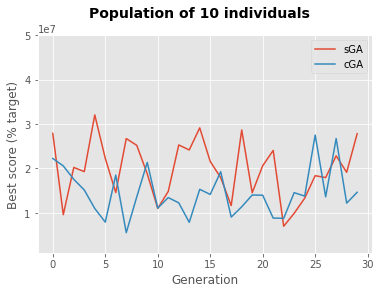

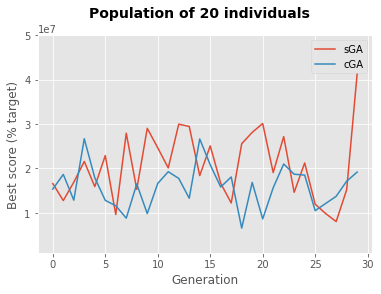

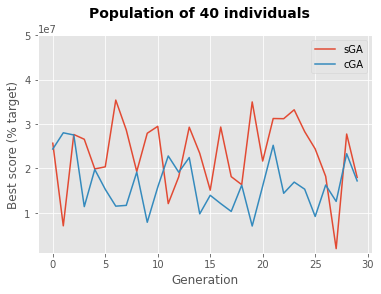

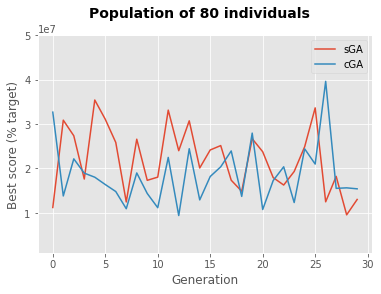

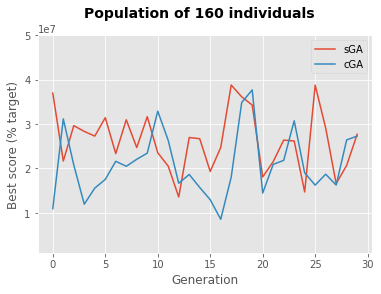

In [5]:
################################################################################
## Imports

import math
import random
import numpy
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Population sizes
sizes = [10, 20, 40, 80, 160]

# Number of tests
tests = 30

# Fitness of the global solution
global_fitness = 15

# Data
data = [0] * 15

# Define fitness function
def fitness_function(individual, data=None):
  sum = 0
  for i, u in enumerate(individual[:-1]):
    sum += 100 * pow(pow(u, 2) + individual[i + 1], 2) + pow(u - 1, 2)
  return sum

# Define the key field for sorting
def get_key(obj):
  return obj.fitness

################################################################################
## Simple Genetic Algorithm (sGA)

# Best fitness of each execution
fitness_sga = []

# Create a new individual
def create_individual(data):
  # Set mutation range
  mrange = 2 - (math.pi - math.e)
  # Generate a random individual
  individual = []
  for d in data:
    individual.append(random.uniform(d - mrange, d + mrange))
  # Return a new individual
  return individual

# Set evolution function
def run(self):
  # Initialize seed data with random values
  model_size = len(self.seed_data)
  for i in range(model_size):
    self.seed_data[i] = random.uniform(0, model_size)
  # Run evolution
  self.create_first_generation()
  for _ in range(1, self.generations):
    self.create_next_generation()

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    sga = pyeasyga.GeneticAlgorithm(data, population_size=ps)
    # Update default functions
    sga.create_individual = create_individual
    sga.run = run
    # Set fitness function
    sga.fitness_function = fitness_function
    # Run sGA
    sga.run(sga)
    # Get best individual
    fitness, result = sga.best_individual()
    popfit.append(fitness)
  fitness_sga.append(popfit)

################################################################################
## Compact Genetic Algorithm (cGA)

# Best fitness of each execution
fitness_cga = []

# Update probability vector
def update_prob(population, prob):
  # Update probability vector with the best results
  for i in range(len(prob)):
    # Mean and standard deviation of the ith element
    aux = []
    for item in population:
      mean = item.genes[i]
      aux.append(mean)
    # Update mean and stdev
    prob[i] = numpy.mean(aux), numpy.std(aux)

# Create a new individual
def create_individual(prob):
  # Find the mean of the probability vector
  mean = numpy.mean(prob)
  # Find the standard deviation of the probability vector
  stdev = numpy.std(prob, ddof=1)
  stdev = stdev if stdev != 0.0 else 2 - (math.pi - math.e)
  # Generate a random individual from a normal distribuition
  individual = numpy.random.normal(mean, stdev, len(prob))
  # Return a new individual
  return pyeasyga.Chromosome(individual)

# Set evolution function
def run(self):
  # Initialize the max number of individuals in a offspring
  offspring_max = int(self.population_size / 2)
  # Initialize best solution
  best = None
  # Initialize best individuals population
  k = int(self.population_size / 3)
  population = []
  # Initialize probability vector
  prob = []
  model_size = len(self.seed_data)
  std_stdev = model_size * (math.pi - math.e)
  for i in range(model_size):
    prob.append((random.uniform(0, model_size), std_stdev))
  # Run `i` generations
  for _ in range(self.generations):
    # Create individuals
    for _ in range(offspring_max):
      downward = self.create_individual(prob)
      downward.fitness = self.fitness_function(downward.genes)
      population.append(downward)
    # Update best individuals population
    population.sort(key=get_key, reverse=True)
    population = population[:k]
    best = population[0]
    # Update the probability vector based on the success of each bit
    update_prob(population, prob)
  # Add final solution
  self.current_generation.append(best)

for ps in sizes:
  popfit = []
  for _ in range(tests):
    # Initialize genetic algorithm
    cga = pyeasyga.GeneticAlgorithm(data, population_size=ps)
    # Set create individual function
    cga.create_individual = create_individual
    # Set fitness function
    cga.fitness_function = fitness_function
    # Set evolution function
    cga.run = run
    # Run evolution
    cga.run(cga)
    # Get best individual
    fitness, result = cga.best_individual()
    popfit.append(fitness)
  fitness_cga.append(popfit)

################################################################################
## Plot comparison charts

for i in range(len(sizes)):
  # Plot
  fig = plt.figure()
  fig.suptitle('Population of ' + str(sizes[i]) + ' individuals',
     fontsize=14, fontweight='bold')
  line_sga, = plt.plot(fitness_sga[i])
  line_cga, = plt.plot(fitness_cga[i])
  plt.ylim(1000000, 50000000)
  plt.legend([line_sga, line_cga], ['sGA', 'cGA'])
  plt.xlabel('Generation')
  plt.ylabel('Best score (% target)')
  plt.show()

################################################################################